In [1]:
import random
import librosa
import librosa.display
from scipy.ndimage import zoom
# import scipy
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf
from typing import Union

%matplotlib inline

In [3]:
# @Psychoacoustic
def fourier_db(stft):
    fourier_abs = np.abs(stft)
    dB = 20 * np.log10(fourier_abs / np.max(fourier_abs))
    return dB

# Create psychoacoustically relevant frequency filters
def freq_filters(cents_interval: int) -> list:
    f0 = 27.5
    cents = range(0,11500,cents_interval) # Until 19KHz 300 cents = minor 3rd filters
    fil_freq = np.round([f0*(pow((2**((1.0/1200))),i)) for i in cents])
    return fil_freq

# @Augmentation
def noise_in_freq_range(signal: np.ndarray, low_freq: float, high_freq: float, noise_level_dB: float, band_pass: bool = False) -> np.ndarray:
    """
    Apply noise to a specific frequency range of a Short-Time Fourier Transform (STFT).

    Parameters:
    -----------
    stft : numpy.ndarray
        The input STFT of the audio signal.

    low_freq : float
        The lower bound of the frequency range (in Hz) to which noise will be applied.

    high_freq : float
        The upper bound of the frequency range (in Hz) to which noise will be applied.

    noise_level_dB : float
        The noise level in decibels (dB). This value determines the amplitude of the noise added.

    band_pass : bool, optional, default: False
        If True, the noise will replace the values in the specified frequency range, acting as a band-pass filter.
        If False, the noise will be added to the existing values in the specified frequency range.

    Returns:
    --------
    numpy.ndarray
        The time-domain audio signal with noise added to the specified frequency range.

    Description:
    ------------
    The `noise_in_freq_range` function adds or replaces noise in a specific frequency range of an audio signal's STFT.
    The noise level is specified in decibels and converted to a linear scale for processing. The function allows for
    two modes of operation:
    - Additive noise: Noise is added to the existing values in the specified frequency range.
    - Band-pass noise: Noise replaces the existing values in the specified frequency range, effectively acting as a
      band-pass filter.
    """
    audio_file, sr = librosa.load(signal, duration=5)
    stft = librosa.stft(audio_file, n_fft=n_fft)
    stft_mag, stft_phase = librosa.magphase(stft)
    
    # Find the indices of the frequency bins that lie within the desired range
    fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))#[0]
    
    # Convert noise level from dB to linear scale
    noise_level_linear = 10**(noise_level_dB / 20.0)

    # Apply noise to the magnitude of the specified frequency bins
    noise = np.random.randn(*stft_mag.shape) * noise_level_linear
    
    if band_pass == False:
        # Add noise to the original values
        stft_mag[freq_bins, :] += noise[freq_bins, :]

    else:
        # Replace the values with noise, acting as a band-pass filter
        stft_mag[freq_bins, :] = noise[freq_bins, :]

    # Combine the modified magnitude with the original phase
    D_noisy = stft_mag * stft_phase

    return D_noisy

def time_displacement(signal: Union[str, np.ndarray], noise: bool = False, duration: float = 5.0, n_fft: int = 1024) -> np.ndarray:
    """
    Applies time displacement to an audio signal and returns its Short-Time Fourier Transform (STFT).

    Parameters:
    signal (Union[str, np.ndarray]): The input audio signal. It can be either a file path (str) to the audio file
                                     or a preloaded NumPy array representing the audio signal.
    noise (bool): If True, the function will add random noise to the padded sections. Default is False.
    duration (float): The duration (in seconds) to which the audio file should be trimmed when loading. Default is 5.0 seconds.
    n_fft (int): The number of FFT components for the STFT. Default is 2048.

    Returns:
    np.ndarray: The STFT of the time-displaced audio signal.

    Example:
    >>> stft = time_displacement('path/to/audio/file.wav', noise=True)
    >>> print(stft.shape)
    
    Notes:
    - If the input is a file path, the audio will be loaded using librosa with the specified duration.
    - The time displacement randomly shifts the signal forwards or backwards by up to one-third of its length.
    - Padding is added to fill in the gaps created by the displacement. The padding can be either zeros or random noise.
    """
    if isinstance(signal, str):
        # Load the audio file if a file path is provided
        signal_load, sr = librosa.load(signal, duration=duration)
    else:
        # Assume the input is already a loaded signal
        signal_load = signal
    
    start_ = int(np.random.uniform(-len(signal_load) / 3, len(signal_load) / 3))
    print('Time displacement:', start_)
    
    padding = np.random.uniform(-0.01, 0.01, size=abs(start_)) if noise else np.zeros(abs(start_))
    
    if start_ >= 0:
        ts = np.concatenate((signal_load[start_:], padding))
    else:
        ts = np.concatenate((padding, signal_load[:start_]))
    
    ts_stft = librosa.stft(ts, n_fft=n_fft)
    return ts_stft

def time_stretch_with_padding(signal: Union[str, np.ndarray], speed_range=(0.7, 1.3), noise_level=0.001, n_fft: int = 1024) -> np.ndarray:
    
    """
    Apply time stretching to the input signal with optional noise padding to match the original length.

    Parameters:
    -----------
    signal: numpy.ndarray
        The input audio signal to be time-stretched.

    speed_range: tuple of float, optional, default: (0.7, 1.3)
        The range (min, max) of the speed rate for stretching. Lower value means faster playback, higher means slower.

    noise_level: float, optional, default: 0.001
        The range for the uniform noise used for padding. Noise will be in the range [-noise_level, noise_level].

    Returns:
    --------
    numpy.ndarray
        The time-stretched and padded (if necessary) audio signal, with the same length as the input signal.
    """
    if isinstance(signal, str):
    # Load the audio file if a file path is provided
        signal, sr = librosa.load(signal, sr=None, duration=5)
    
    else:
        # Assume the input is already a loaded signal
        sr = 22050  # Default sampling rate for librosa
    
    # Initialize random number generator
    rng = np.random.default_rng()
    
    min_speed, max_speed = speed_range
    speed_rate = rng.uniform(low=min_speed, high=max_speed)
    print('Speed rate: ', speed_rate, '(<1 - faster, >1 - slower)')

    # Perform time stretching by resampling
    stretched_signal = zoom(signal, speed_rate)

    # Calculate padding lengths
    original_len = len(signal)
    stretched_len = len(stretched_signal)
    pad_len = max(0, original_len - stretched_len)
    cut_len = max(0, stretched_len - original_len)

    # Generate padding noise
    if pad_len > 0:
        noise = rng.uniform(-noise_level, noise_level, size=pad_len)
        pad_before = noise[: int(pad_len / 2)]
        pad_after = noise[int(pad_len / 2) :]
    else:
        pad_before = np.empty(0)
        pad_after = np.empty(0)

    # Adjust the length of the output to match the original length
    if stretched_len < original_len:
        stretched_signal = np.concatenate((pad_before, stretched_signal, pad_after))
    else:
        start_index = int(cut_len / 2)
        stretched_signal = stretched_signal[start_index : start_index + original_len]
        
    stretched_stft = librosa.stft(stretched_signal, n_fft=n_fft)
    return stretched_stft

def random_time_stretch(signal: Union[str, np.ndarray], n_fft: int, speed_range=(0.7, 1.3), noise_level=0.001) -> np.ndarray:
    """
    Apply time stretching to the input signal with optional noise padding to match the original length.

    Parameters:
    -----------
    signal: Union[str, np.ndarray]
        The input audio signal to be time-stretched.

    speed_range: tuple of float, optional, default: (0.7, 1.3)
        The range (min, max) of the speed rate for stretching. Lower value means slower playback, higher means faster.

    noise_level: float, optional, default: 0.001
        The range for the uniform noise used for padding. Noise will be in the range [-noise_level, noise_level].

    Returns:
    --------
    np.ndarray
        The time-stretched and padded (if necessary) audio signal, with the same length as the input signal.
    """

    if isinstance(signal, str):
        # Load the audio file if a file path is provided
        signal, sr = librosa.load(signal, sr=None, duration=5)
    else:
        # Assume the input is already a loaded signal
        sr = 22050  # Default sampling rate for librosa

    # Initialize random number generator
    rng = np.random.default_rng()

    # Generate a random speed rate within the given range
    speed_rate = rng.uniform(low=speed_range[0], high=speed_range[1])
    print(speed_rate)

    # Perform time stretching using librosa
    stretched_signal = librosa.effects.time_stretch(signal, rate=speed_rate)

    # Calculate padding lengths
    original_len = len(signal)
    stretched_len = len(stretched_signal)
    pad_len = max(0, original_len - stretched_len)
    cut_len = max(0, stretched_len - original_len)

    # Generate padding noise
    if pad_len > 0:
        noise = rng.uniform(-noise_level, noise_level, size=pad_len)
        pad_before = noise[: int(pad_len / 2)]
        pad_after = noise[int(pad_len / 2) :]
    else:
        pad_before = np.empty(0)
        pad_after = np.empty(0)

    # Adjust the length of the output to match the original length
    if stretched_len < original_len:
        stretched_signal = np.concatenate((pad_before, stretched_signal, pad_after))
    else:
        start_index = int(cut_len / 2)
        stretched_signal = stretched_signal[start_index : start_index + original_len]
        
    stretched_stft = librosa.stft(stretched_signal, n_fft=n_fft)
    return stretched_stft

def mix_up(signal, patch, noise_level_dB, low_freq, high_freq, n_fft=1024):#, sr=22050, mono=False):
    """
    Apply a patch from a patch audio file to the original STFT in a specific frequency range with a given noise level.

    Parameters:
    -----------
    stft : numpy.ndarray
        The STFT of the original audio signal.
        
    patch : str
        Path to the patch audio file to be applied.
        
    noise_level_dB : float
        The noise level in decibels (dB) to be applied to the patch.
        
    low_freq : float
        The lower bound of the frequency range (in Hz) to which the patch will be applied.
        
    high_freq : float
        The upper bound of the frequency range (in Hz) to which the patch will be applied.
        
    sr : int, optional, default: 22050
        The sampling rate for loading the audio files.
        
    n_fft : int, optional, default: 1024
        The number of FFT components.
        
    duration : float, optional, default: 5
        The duration (in seconds) to load from the patch audio file.
        
    mono : bool, optional, default: False
        If True, the patch audio file will be converted to mono.

    Returns:
    --------
    numpy.ndarray
        The time-domain audio signal with the patch applied to the specified frequency range.
    """
    
    audio_file, sr = librosa.load(signal, mono=True, duration=5)
    patch_file, sr_patch = librosa.load(patch, mono=True)
    
    if len(patch_file) > len(audio_file):
        patch_file = patch_file[:len(audio_file)]
    elif len(patch_file) < len(audio_file):
        if patch_file.ndim == 1:  # Mono
            zeros = np.zeros(len(audio_file) - len(patch_file))
        else:  # Stereo
            zeros = np.zeros((patch_file.shape[0], len(audio_file) - len(patch_file[0])))
        patch_file = np.concatenate((patch_file, zeros), axis=-1)
        
    audio_stft = librosa.stft(audio_file, n_fft=n_fft)
    patch_stft = librosa.stft(patch_file, n_fft=n_fft)
    
    # Compute magnitude and phase for the patch and original STFT
    stft_mag_patch, stft_phase_patch = librosa.magphase(patch_stft)
    stft_mag_orig, stft_phase_orig = librosa.magphase(audio_stft)

    # Convert noise level from dB to linear scale
    noise_level_linear = 10**(noise_level_dB / 20.0)
    patch_db = stft_mag_patch * noise_level_linear

    # Find the indices of the frequency bins that lie within the desired range
    fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

    # Apply the patch to the original STFT magnitude
    stft_mag_orig[freq_bins, :] += patch_db[freq_bins, :]

    # Reconstruct the STFT with the original phase
    mix_up = stft_mag_orig * stft_phase_orig

    # Perform the inverse STFT to convert back to the time domain
    mix_up_audio = librosa.istft(mix_up)

    return mix_up_audio

def specaug_time_mask(duration, hop_length, signal_stft, patch_stft):
    """Performs random time masking.

    Args:
        duration (float): Duration of the audio signal in seconds.
        hop_length (float): Hop length between STFT windows in seconds.
        signal_stft (np.ndarray): Short-time Fourier transform of the signal.
        patch_stft (np.ndarray): Short-time Fourier transform of the noise patch.

    Returns:
        np.ndarray: Time-domain signal after time masking.
    """

    num_time_steps = int(duration / hop_length)  # Calculate number of time steps

    if num_time_steps <= 0:
        raise ValueError("Duration must be greater than hop length for time masking.")

    mask_length = random.randint(0, num_time_steps - 1)  # Ensure mask stays within bounds
    starting_time = random.randint(0, num_time_steps - mask_length)

    signal_stft[:, starting_time:starting_time + mask_length] = patch_stft[:, starting_time:starting_time + mask_length]
    # signal_time_mod = librosa.istft(signal_stft)
    return signal_stft


def specaug_freq_mask(width, signal_stft, patch_stft, n_mels, sr_signal):
    """Performs random frequency masking.

    Args:
        width (int): Width of the frequency mask in Mel bands.
        signal_stft (np.ndarray): Short-time Fourier transform of the signal.
        patch_stft (np.ndarray): Short-time Fourier transform of the noise patch.
        n_mels (int): Number of Mel bands used in the mel spectrogram.

    Returns:
        np.ndarray: Mel spectrogram of the signal after frequency masking.
    """

    signal_mag, signal_phase = librosa.magphase(signal_stft)
    patch_mag, patch_phase = librosa.magphase(patch_stft)

    signal_mel = librosa.feature.melspectrogram(S=signal_mag, sr=sr_signal, n_mels=n_mels, n_fft=n_fft)
    patch_mel = librosa.feature.melspectrogram(S=patch_mag, sr=sr_signal, n_mels=n_mels, n_fft=n_fft)

    # Ensure mask width stays within Mel band limits
    if width > n_mels:
        raise ValueError("Frequency mask width cannot exceed the number of Mel bands.")

    mask_width = random.randint(0, width)
    starting_freq = random.randint(0, n_mels - mask_width)

    signal_mel[starting_freq:starting_freq + mask_width] = patch_mel[starting_freq:starting_freq + mask_width]
    return signal_mel

def spec_augmentation(signal, patch, duration, hop_length, width, n_mels, n_fft):
    signal_file, sr_signal = librosa.load(signal, duration=5)
    patch_file, sr_patch = librosa.load(patch, duration=5)
    signal_stft = librosa.stft(signal_file, n_fft=n_fft)
    patch_stft = librosa.stft(patch_file, n_fft=n_fft)
    signal_stft_mod = specaug_time_mask(duration, hop_length, signal_stft, patch_stft)
    signal_mel = specaug_freq_mask(width, signal_stft_mod, patch_stft, n_mels, sr_signal)
    return signal_mel

# @Plots

def plot_spectrogram(signal, sr, title, hop_length):
    mag = np.abs(signal) ** 2
    signal_dB = librosa.power_to_db(mag, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(signal_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='YlGn')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{title}')
    plt.tight_layout()
    plt.show()

def plot_fourier(signal, fft_freqs, title, fill_area=None, fill=False):
    plt.figure(figsize=(8, 4))
    plt.plot(fft_freqs[:300], signal.T[10][:300])
    
    if fill and fill_area is not None:
        # Fill the gray area
        plt.fill_between(fill_area, plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.5)
        if fill_area[0] > 1000:
            plt.xlim(fill_area[0]-1000, fill_area[1]+1000)
        else:
            plt.xlim(fill_area[0]-500, fill_area[1]+500)
    
    plt.xticks(fill_area)
    plt.ylim(-80,0)
    # plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title(title)
    plt.show()
    plt.close()

def plot_compare(original_audio, modified_audio):
    plt.figure (figsize=(8, 6))
    plt.subplot (2, 1, 1)
    librosa.display.specshow (librosa.amplitude_to_db (np.abs (librosa.stft (original_audio)), ref=np.max),
                              sr=sr, y_axis='log', x_axis='time')
    plt.title ('Original Audio')
    plt.colorbar (format='%+2.0f dB')
    plt.subplot (2, 1, 2)
    librosa.display.specshow (librosa.amplitude_to_db (np.abs (librosa.stft (modified_audio)), ref=np.max),
                              sr=sr, y_axis='log', x_axis='time')
    plt.title ('Modified audio')
    plt.colorbar (format='%+2.0f dB')
    plt.tight_layout ()
    plt.show ()
    
def play_file(signal):
    audio = librosa.istft (signal)
    return ipd.Audio (audio, rate=22050)



In [4]:
# Use cases

signal = fr'C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\redhot.wav'
patch = fr'C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\duke.wav'
duration = 70000 # in samples
hop_length = 256
width = 40
n_mels = 128
n_fft = 1024


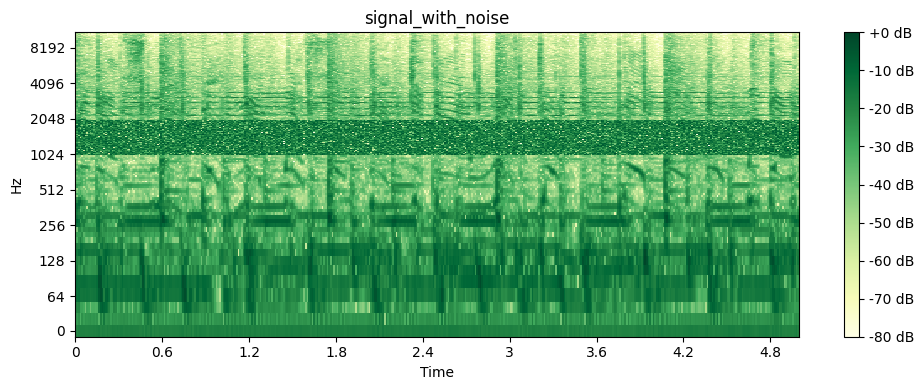

In [5]:
# Add noise to signal  on a defined FR

low_freq = 1000
high_freq = 2000
noise_level_dB = 20
signal_with_noise = noise_in_freq_range(signal, low_freq, high_freq, noise_level_dB, band_pass=False)
plot_spectrogram(signal_with_noise, 22050, 'signal_with_noise', hop_length)

Filtering from 1000 to 2000


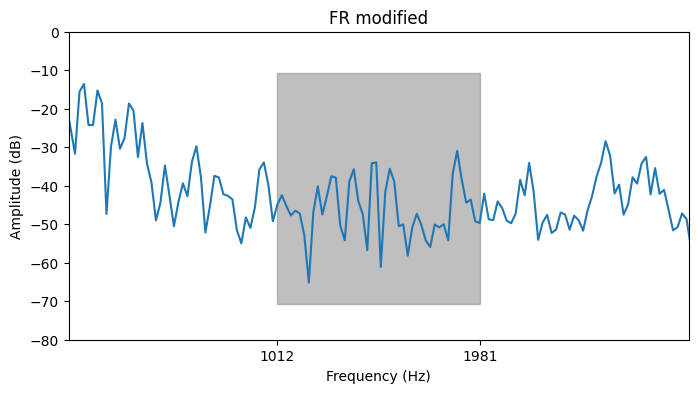

In [6]:
# Define frequency range for further augmentations

print(f'Filtering from {low_freq} to {high_freq}')
fft_freqs = librosa.fft_frequencies(sr=22050, n_fft=n_fft)
freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

# Plot FR
signal_file, sr = librosa.load(signal, duration=5)
signal_stft = librosa.stft(signal_file, n_fft=n_fft)
signal_db = fourier_db(signal_stft)
gray_area_x = [fft_freqs[freq_bins[0]], fft_freqs[freq_bins[-1]]]
plot_fourier(signal=signal_db, fft_freqs=fft_freqs, title='FR modified', fill_area=gray_area_x, fill=True)

Time displacement: 9083


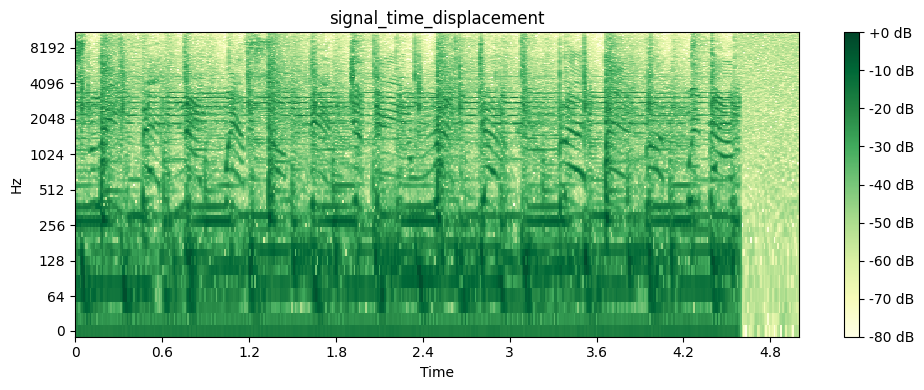

In [7]:
# time displacement - introduces noise/silence to change the start/end point of file keeping its length

signal_time_displacement = time_displacement(signal, noise=True)
# ipd.Audio(ts, rate=22050)
plot_spectrogram(signal_time_displacement, 22050, 'signal_time_displacement', hop_length)

Speed rate:  1.0667785899292672 (<1 - faster, >1 - slower)


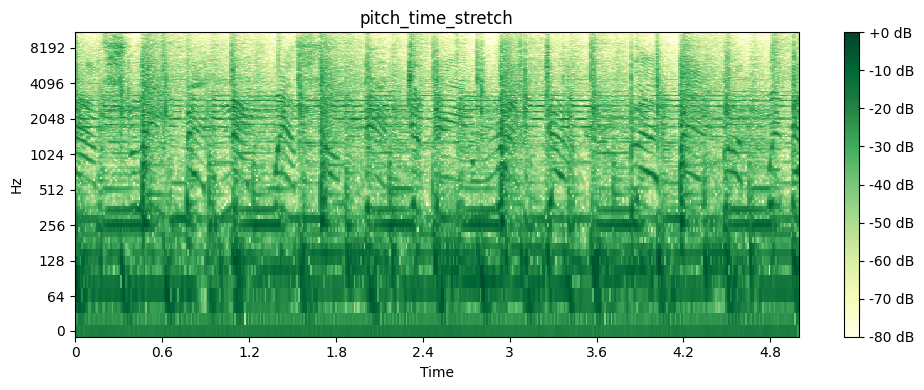

In [8]:
# changing the speed rate and the pitch (proportionally)

pitch_time_stretch = time_stretch_with_padding(signal, speed_range=(0.7, 1.3), noise_level=0.001, n_fft=n_fft)
# time_stretch_sound = librosa.istft(pitch_time_stretch)
# ipd.Audio(time_stretch_sound, rate=22050)
plot_spectrogram(pitch_time_stretch, 22050, 'pitch_time_stretch', hop_length)

1.0612265907845386


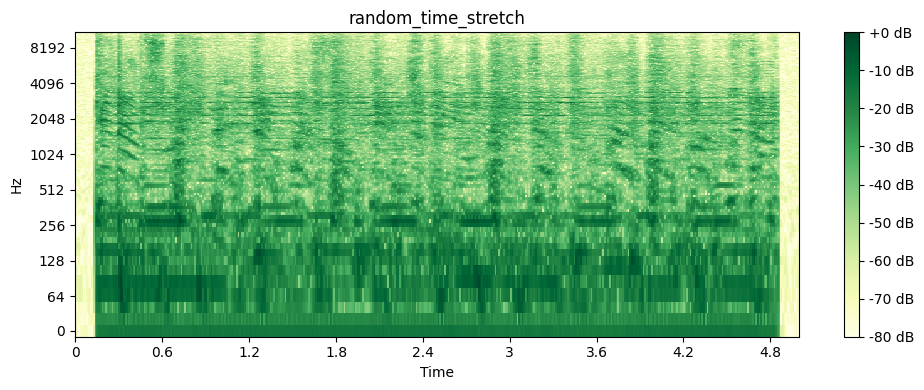

In [9]:
# changing length without changing pitch (time stretch)
random_time_stretch = random_time_stretch(signal, n_fft)
# time_stretch_sound = librosa.istft(time_stretch)
# ipd.Audio(time_stretch_sound, rate=22050)
plot_spectrogram(random_time_stretch, 22050, 'random_time_stretch', hop_length)

In [10]:
# create psychoacoustic fitlers
filters = freq_filters(cents_interval=100)
# print(filters)

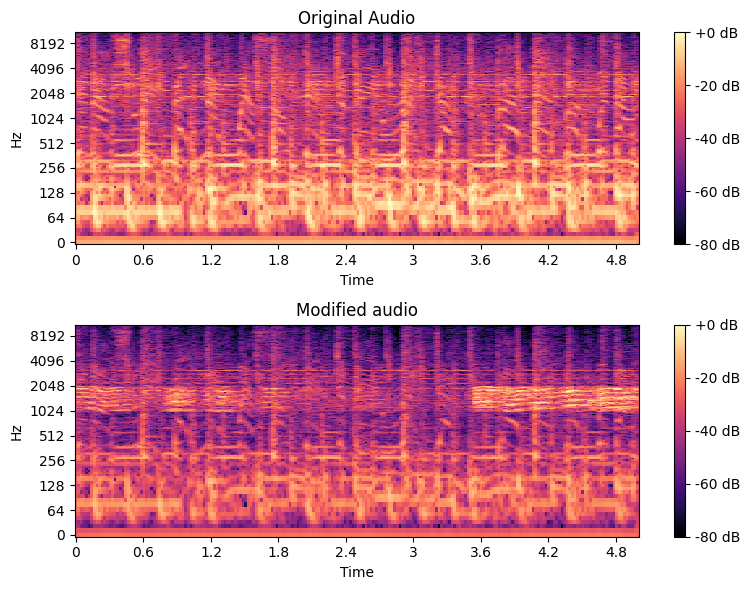

In [11]:
# MixUp augmentation technique according to Inoue(2018)

mix_up_audio = mix_up(signal=signal, patch=patch,low_freq=low_freq, high_freq=high_freq, noise_level_dB=noise_level_dB)

# # Save new audio
sf.write('mix_up_audio.wav', mix_up_audio, sr)
ipd.Audio(mix_up_audio, rate=sr)
plot_compare(signal_file, mix_up_audio)

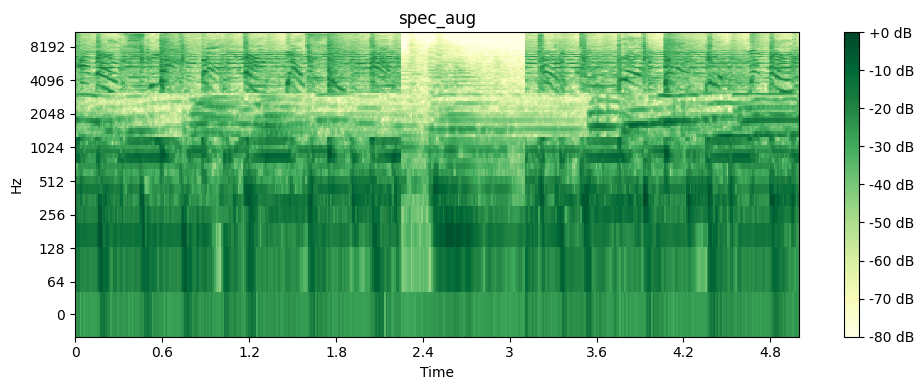

In [12]:
# def spec_augmentation(signal, patch, duration, hop_length, width, n_mels):
    
spec_aug = spec_augmentation(signal=signal, patch=patch, duration=duration, hop_length=hop_length, width=width, n_mels=n_mels, n_fft=n_fft)
plot_spectrogram(spec_aug, 22050, 'spec_aug', hop_length)